In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

/home/bionicdl-saber/.local/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/home/bionicdl-saber/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')


In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
# from notebooks import visualization
import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
ckpt_filename = '../checkpoints/model.ckpt-2234288'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-2234288


In [37]:
print len(ssd_anchors[0])
print ssd_anchors[0][0] #y
print ssd_anchors[0][1] #x 
print ssd_anchors[0][2] #h
print ssd_anchors[0][3] #w



4
[[[0.01333333]
  [0.01333333]
  [0.01333333]
  ...
  [0.01333333]
  [0.01333333]
  [0.01333333]]

 [[0.04      ]
  [0.04      ]
  [0.04      ]
  ...
  [0.04      ]
  [0.04      ]
  [0.04      ]]

 [[0.06666667]
  [0.06666667]
  [0.06666667]
  ...
  [0.06666667]
  [0.06666667]
  [0.06666667]]

 ...

 [[0.94666666]
  [0.94666666]
  [0.94666666]
  ...
  [0.94666666]
  [0.94666666]
  [0.94666666]]

 [[0.97333336]
  [0.97333336]
  [0.97333336]
  ...
  [0.97333336]
  [0.97333336]
  [0.97333336]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [1.        ]
  [1.        ]
  [1.        ]]]
[[[0.01333333]
  [0.04      ]
  [0.06666667]
  ...
  [0.94666666]
  [0.97333336]
  [1.        ]]

 [[0.01333333]
  [0.04      ]
  [0.06666667]
  ...
  [0.94666666]
  [0.97333336]
  [1.        ]]

 [[0.01333333]
  [0.04      ]
  [0.06666667]
  ...
  [0.94666666]
  [0.97333336]
  [1.        ]]

 ...

 [[0.01333333]
  [0.04      ]
  [0.06666667]
  ...
  [0.94666666]
  [0.97333336]
  [1.        ]]

 [[0.0

## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

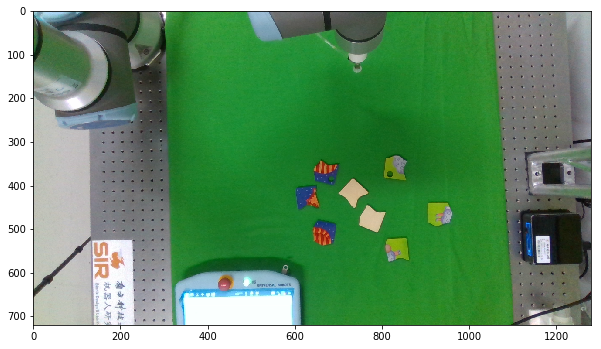

In [15]:
# Test on some demo image and visualize output.
path = '../demo/'
# image_names = sorted(os.listdir(path))
# img = mpimg.imread(path + image_names[-5])

# img_name = '333.png'
# img = mpimg.imread(path + img_name)
# img2 = cv2.imread(path + img_name)
# img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img = mpimg.imread('/home/bionicdl-saber/Pictures/3_Color.png')
# img = cv2.imread('/home/bionicdl-saber/Pictures/1_Color.png')

rclasses, rscores, rbboxes =  process_image(img)

# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)



In [49]:
rbboxes

array([[0.43142086, 0.13120198, 0.6667405 , 0.29734522],
       [0.        , 0.0958563 , 0.16125718, 0.26667786],
       [0.4554279 , 0.8825626 , 0.5691418 , 0.9693087 ],
       [0.23277289, 0.06421447, 0.51665753, 0.24199635],
       [0.04870756, 0.16734993, 0.3313185 , 0.34198666]], dtype=float32)

In [48]:
img.shape[0]

720

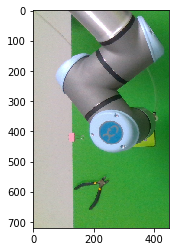

In [45]:
ccc = img[:,0:450,:]
plt.imshow(ccc)
plt.show()

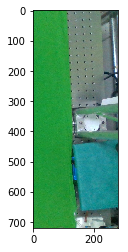

In [54]:
ccc = img[:,1000:,:]
plt.imshow(ccc)
plt.show()

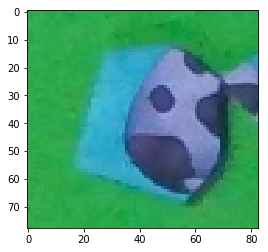

In [13]:
ymin = int(rbboxes[0][0]*img.shape[0])
xmin = int(rbboxes[0][1]*img.shape[1])
ymax = int(rbboxes[0][2]*img.shape[0])
xmax = int(rbboxes[0][3]*img.shape[1])
kkk = img[ymin-10:ymax+10,xmin-10:xmax+10,:]
plt.imshow(kkk)
plt.show()


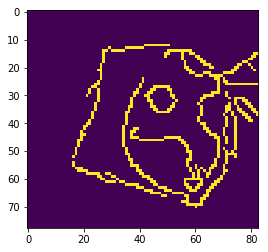

TypeError: 'NoneType' object has no attribute '__getitem__'

In [51]:
gray = cv2.cvtColor(kkk,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 80,170,5)
plt.imshow(edges)
plt.show()
# lines = cv2.HoughLines(edges,1,np.pi/180,200)
# for rho,theta in lines[0]:
#     a = np.cos(theta) 
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     cv2.line(kkk,(x1,y1),(x2,y2),(0,0,255),2)

minLineLength = 80
maxLineGap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 10, minLineLength, maxLineGap)

for x1,y1,x2,y2 in lines[0]:
    cv2.line(kkk, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(kkk)
plt.show()